In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input,GlobalMaxPooling1D,Embedding,TextVectorization,LayerNormalization,MultiHeadAttention)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import re
import string
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer)
from keras.models import Model
from keras import Input

2024-07-26 05:39:04.962786: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-26 05:39:04.962935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-26 05:39:05.105211: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
!pip install gdown
import gdown
import os

# Create Directory
directory="/content"
if not os.path.exists(directory):
    os.makedirs(directory)

# # a file
# # same as the above, and you can copy-and-paste a URL from Google Drive with fuzzy=True
url = "https://drive.google.com/file/d/1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW/view"
output='/content/train_data.csv'
gdown.download(url=url, output=output, fuzzy=True)
url2 = "https://drive.google.com/file/d/1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB/view"
output2='/content/test_data.csv'
gdown.download(url=url2, output=output2, fuzzy=True)
url3 = "https://drive.google.com/file/d/1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h/view"
output3='/content/title_brand.csv'
gdown.download(url=url3, output=output3, fuzzy=True)



/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Downloading...
From (original): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW
From (redirected): https://drive.google.com/uc?id=1-AlW7oNJHaqi3xk_9dWHUS52Dzl_FmFW&confirm=t&uuid=e92bfe95-886b-4f6d-871a-ca38412d4ab9
To: /content/train_data.csv
100%|██████████| 635M/635M [00:09<00:00, 64.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-8TsrqTRFP-q9TM-6HinhO0ZVXFHq9TB
To: /content/test_data.csv
100%|██████████| 15.6M/15.6M [00:00<00:00, 46.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I9aPAvvYgQWdHGKtnd7IeTGXpx8vOm4h
To: /content/title_brand.csv
100%|██████████| 97.3M/97.3M [00:00<00:00, 196MB/s]


'/content/title_brand.csv'

In [3]:
train_data = pd.read_csv('/content/train_data.csv')

/tmp/ipykernel_24/359229733.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  train_data = pd.read_csv('/content/train_data.csv')


In [4]:
train_data.head()

,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime
0,2,NaN,False,2016-11-11,A2OSUEZJIN7BI,0511189877,NaN,Chris,I have an older URC-WR7 remote and thought thi...,Cannot Learn,1478822400
1,5,NaN,True,2016-06-06,A2NETQRG6JHIG7,0511189877,NaN,Qrysta White,First time I've EVER had a remote that needed ...,zero programming needed! Miracle!?,1465171200
2,4,NaN,True,2016-03-10,A12JHGROAX49G7,0511189877,NaN,Linwood,Got them and only 2 of them worked. company ca...,Works Good and programs easy.,1457568000
3,5,NaN,True,2016-01-14,A1KV65E2TMMG6F,0511189877,NaN,Dane Williams,I got tired of the remote being on the wrong s...,Same as TWC remote,1452729600
4,5,NaN,True,2016-10-20,A280POPEWI0NSA,0594459451,NaN,Kristina H.,After purchasing cheap cords from another webs...,Good Quality Cord,1476921600


In [5]:
train_data.shape

(838944, 11)

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838944 entries, 0 to 838943
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   overall         838944 non-null  int64 
 1   vote            191468 non-null  object
 2   verified        838944 non-null  bool  
 3   reviewTime      838944 non-null  object
 4   reviewerID      838944 non-null  object
 5   asin            838944 non-null  object
 6   style           490613 non-null  object
 7   reviewerName    838717 non-null  object
 8   reviewText      838944 non-null  object
 9   summary         838868 non-null  object
 10  unixReviewTime  838944 non-null  int64 
dtypes: bool(1), int64(2), object(8)
memory usage: 64.8+ MB


In [7]:
# taking care of the 'vote' column
train_data['vote'] = train_data['vote'].str.replace(',', '')
train_data['vote'] = pd.to_numeric(train_data['vote'], errors='coerce')
median_value = train_data['vote'].median()
train_data['vote'].fillna(median_value, inplace=True)

/tmp/ipykernel_24/2484861237.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['vote'].fillna(median_value, inplace=True)


In [8]:
train_data['vote'].unique()

array([4.000e+00, 3.000e+00, 2.000e+00, 1.700e+01, 3.400e+02, 8.000e+00,
       5.000e+00, 1.400e+01, 1.100e+01, 2.900e+01, 1.900e+01, 7.000e+00,
       6.000e+00, 2.800e+01, 3.010e+02, 1.800e+01, 1.000e+01, 9.000e+00,
       3.700e+01, 2.000e+01, 1.200e+01, 3.310e+02, 4.100e+01, 3.300e+01,
       3.800e+01, 1.300e+01, 2.400e+01, 1.600e+01, 2.100e+01, 3.500e+01,
       6.000e+01, 4.800e+01, 1.060e+02, 2.500e+01, 3.200e+01, 4.700e+01,
       1.140e+02, 6.900e+01, 2.300e+01, 5.800e+01, 1.500e+01, 1.570e+02,
       4.400e+01, 6.100e+01, 8.100e+01, 3.400e+01, 2.700e+01, 5.000e+01,
       2.600e+01, 2.200e+01, 3.000e+01, 5.100e+01, 6.700e+01, 9.300e+01,
       1.010e+02, 8.400e+01, 1.540e+02, 3.100e+01, 3.600e+01, 1.710e+02,
       4.000e+01, 5.700e+01, 5.600e+01, 4.300e+01, 6.800e+01, 6.600e+01,
       3.270e+02, 9.100e+01, 1.040e+02, 3.900e+01, 5.300e+01, 9.200e+01,
       1.250e+02, 6.400e+01, 1.580e+02, 9.400e+01, 1.190e+02, 7.200e+01,
       1.280e+02, 1.030e+02, 4.500e+01, 1.100e+02, 

In [9]:
# due to few amount of values in column 'style'
train_data = train_data.drop('style', axis=1)

In [10]:
# to handle the nan values in column 'summary'
train_data = train_data.dropna()

In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838641 entries, 0 to 838943
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         838641 non-null  int64  
 1   vote            838641 non-null  float64
 2   verified        838641 non-null  bool   
 3   reviewTime      838641 non-null  object 
 4   reviewerID      838641 non-null  object 
 5   asin            838641 non-null  object 
 6   reviewerName    838641 non-null  object 
 7   reviewText      838641 non-null  object 
 8   summary         838641 non-null  object 
 9   unixReviewTime  838641 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 64.8+ MB


In [12]:
train_data.describe()

,overall,vote,unixReviewTime
count,838641.000000,838641.00000,8.386410e+05
mean,4.021294,4.60048,1.483167e+09
std,1.344219,11.80418,2.229314e+07
min,1.000000,2.00000,1.451606e+09
25%,3.000000,4.00000,1.464653e+09
50%,5.000000,4.00000,1.479254e+09
75%,5.000000,4.00000,1.499472e+09
max,5.000000,2846.00000,1.538525e+09


## First Analysis Task
* Plotting the distribution of overall ratings
* Checking if the dataset is balanced or not

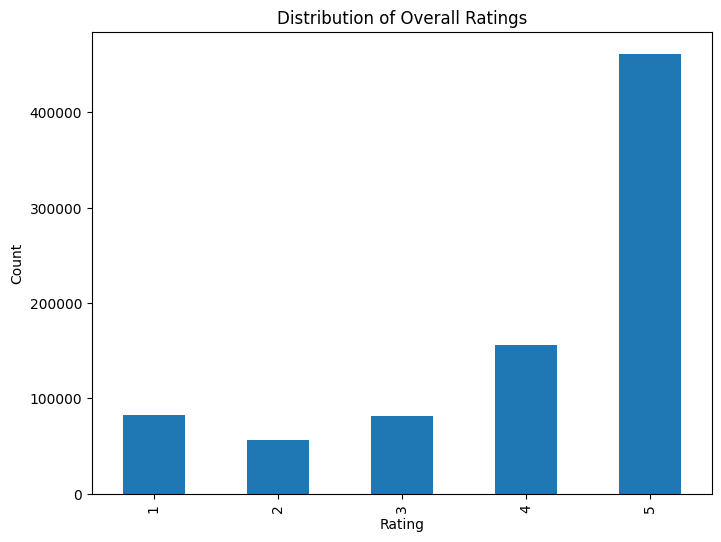

In [13]:
plt.figure(figsize=(8, 6))
train_data['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Due to the large number of samples in the class of five stars against other classes, we can conclude that **the dataset is not balanced**.

Taking care of this, we are going to balance it by **over sampling**!

decreasing the size of the majority classes.

In [14]:
# Define the features and target variable
x = train_data.drop('overall', axis=1)
y = train_data['overall']

In [15]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(x, y)

train_data_resampled = pd.concat([X_resampled, y_resampled], axis=1)

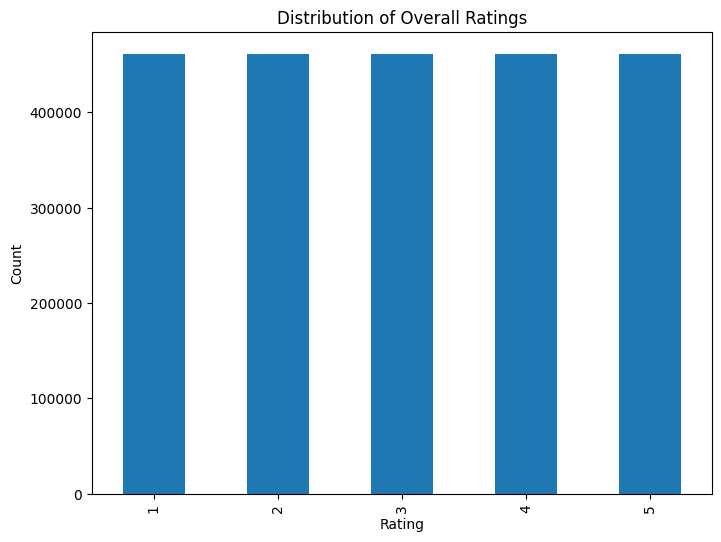

In [16]:
plt.figure(figsize=(8, 6))
train_data_resampled['overall'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Overall Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [17]:
train_data_resampled.shape

(2306525, 10)

## Second Analysis Task


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_24/3698006179.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checking_df['processed_reviewText'] = checking_df['reviewText'].apply(preprocess_text)
/tmp/ipykernel_24/3698006179.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checking_df['sentiment'] = checking_df['overall'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))


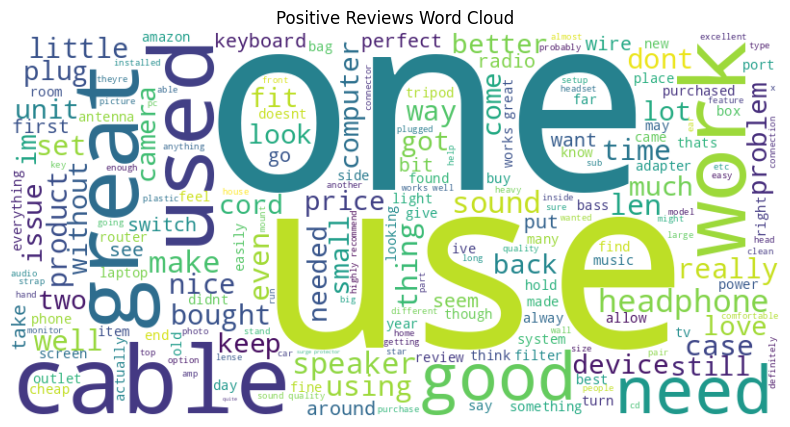

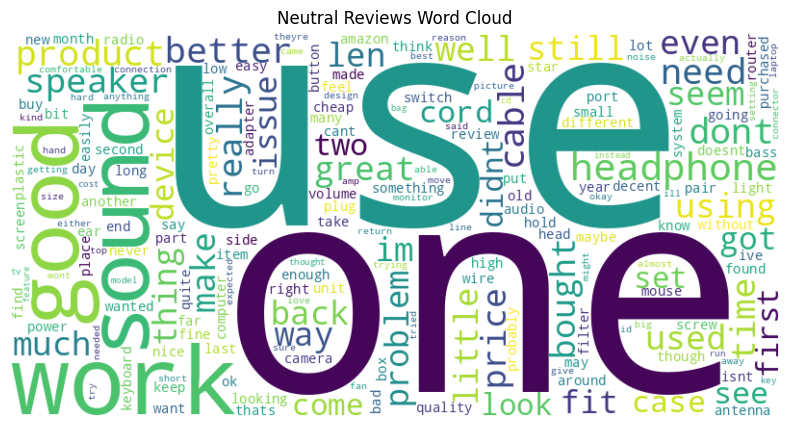

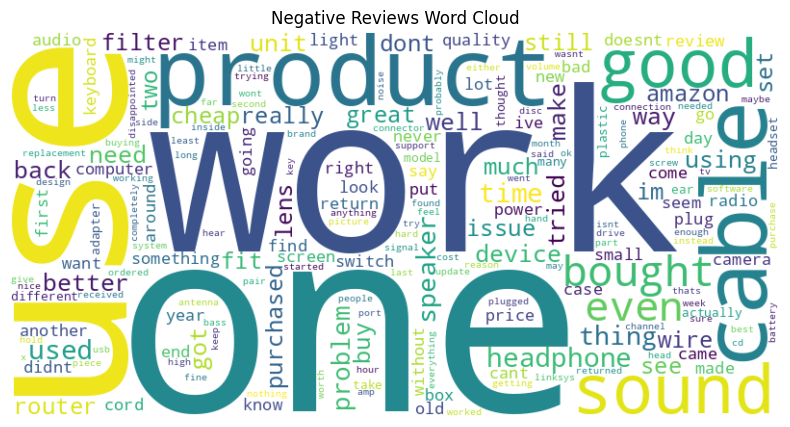

Common words between positive and negative reviews: {'behringers', 'lightroom', 'invited', 'minimum', 'selectivity', 'shoulders', 'cheapfeeling', 'becomes', 'koolatron', 'questions', 'troubles', 'freely', 'ship', 'deliberately', 'seen', 'outlets', 'trace', 'automotive', 'house', 'ikea', 'tank', 'sophisticated', 'delivery', 'laughing', 'shelves', 'yellow', 'quicker', 'horrified', 'engineered', 'offerings', 'threw', 'various', 'qr', 'sanity', 'dark', 'true', 'behind', 'obs', 'quote', 'declined', 'months', 'halves', 'rejection', 'moths', 'load', 'burn', 'adhesives', 'finest', 'indoors', 'artwork', 'songbirds', 'soap', 'alerted', 'court', 'chemicals', 'inefficient', 'necessary', 'changing', 'soundproofing', 'xsplit', 'unit', 'webcam', 'superia', 'sortof', 'tweeters', 'knees', 'chuckled', 'checks', 'splitters', 'orders', 'february', 'shelf', 'rolloff', 'unbalanced', 'bytes', 'cranked', 'monitora', 'bare', 'stutter', 'loses', 'bravo', 'opinions', 'college', 'definition', 'sons', 'belt', 'opa

In [18]:
# working on a small part of the dataset due to less computation cost
checking_df = train_data_resampled.head(20000)

# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# preprocess text
def preprocess_text(text):
    text = text.lower()  # to lowercase
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])  # remove nonalphabetic characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stop words
    return text

# apply preprocessing to reviewText
checking_df['processed_reviewText'] = checking_df['reviewText'].apply(preprocess_text)

# categorize reviews
checking_df['sentiment'] = checking_df['overall'].apply(lambda x: 'positive' if x in [4, 5] else ('neutral' if x == 3 else 'negative'))

# generating word cloud
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# word cloud for each sentiment group
positive_text = ' '.join(checking_df[checking_df['sentiment'] == 'positive']['processed_reviewText'])
neutral_text = ' '.join(checking_df[checking_df['sentiment'] == 'neutral']['processed_reviewText'])
negative_text = ' '.join(checking_df[checking_df['sentiment'] == 'negative']['processed_reviewText'])

generate_wordcloud(positive_text, 'Positive Reviews Word Cloud')
generate_wordcloud(neutral_text, 'Neutral Reviews Word Cloud')
generate_wordcloud(negative_text, 'Negative Reviews Word Cloud')

# analyze common words
positive_words = Counter(positive_text.split())
negative_words = Counter(negative_text.split())

common_words = set(positive_words.keys()).intersection(set(negative_words.keys()))
print(f"Common words between positive and negative reviews: {common_words}")

**Interpretation of common words**:

There might simply be common words both in negative and positive reviews, because there are many words we use that do not carry any specific sentiment by thhemselves, for instance 'chair'. Whoever has used 'chair' in their sentence could have been happy using it or not!

## Third Analysis Task

In [19]:
reviewer_votes = checking_df.groupby(['reviewerID', 'reviewerName'])['vote'].sum().reset_index()

top_reviewers = reviewer_votes.sort_values(by='vote', ascending=False).head(10)

# top 10 reviewers
print("Top 10 Reviewers with Most Useful Comments:")
print(top_reviewers[['reviewerName', 'vote']])

# results in another style
for idx, row in top_reviewers.iterrows():
    print(f"{row['reviewerName']}: {row['vote']} votes")

Top 10 Reviewers with Most Useful Comments:
      reviewerName  vote
10505    Mark King  60.0
11312  Atomic Tofu  36.0
2573   Professor H  28.0
3969       Michael  28.0
16298     Giang Vu  28.0
4981          Bill  24.0
9979         Dan J  24.0
14794    R. Porter  24.0
8274   OrangeCrush  24.0
2315      Kevin G.  24.0
Mark King: 60.0 votes
Atomic Tofu: 36.0 votes
Professor H: 28.0 votes
Michael: 28.0 votes
Giang Vu: 28.0 votes
Bill: 24.0 votes
Dan J: 24.0 votes
R. Porter: 24.0 votes
OrangeCrush: 24.0 votes
Kevin G.: 24.0 votes


## Fourth Analysis Task

/tmp/ipykernel_24/835843668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  checking_df['review_length'] = checking_df['reviewText'].apply(len)


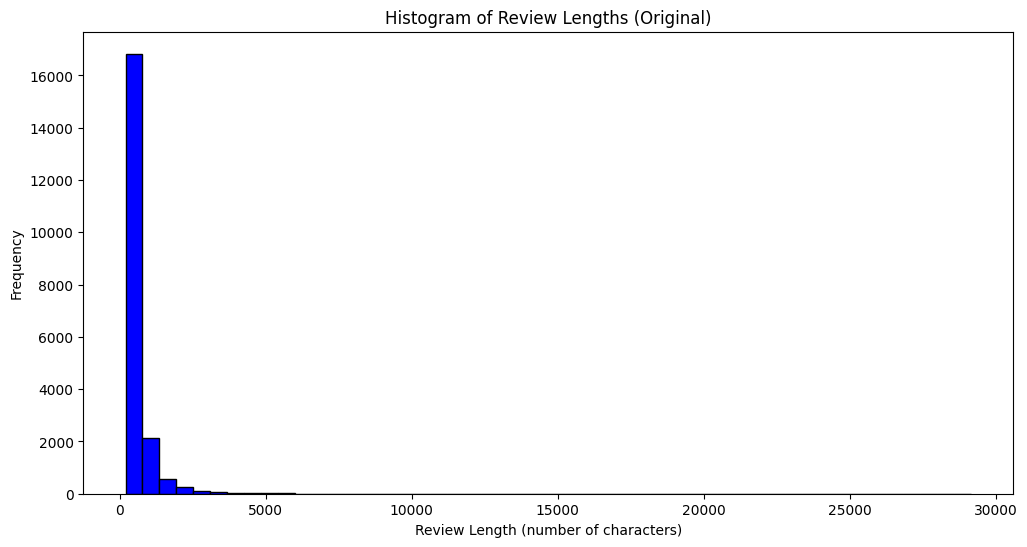

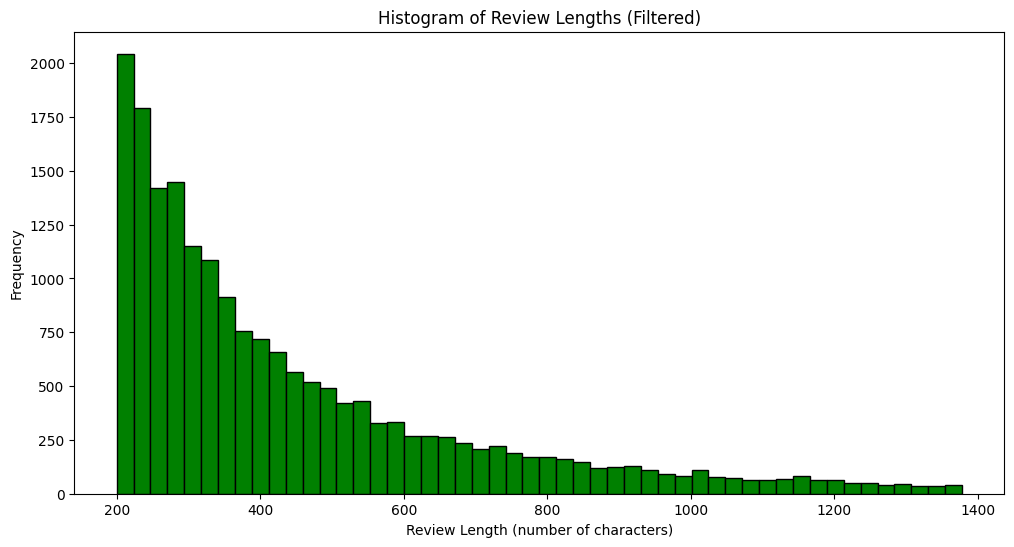

Mean review length: 537.0931
Max review length: 29146
Suggested limit for the number of characters: 1378


In [20]:
# length of each review
checking_df['review_length'] = checking_df['reviewText'].apply(len)

# histogram of the original review lengths
plt.figure(figsize=(12, 6))
plt.hist(checking_df['review_length'], bins=50, color='blue', edgecolor='black')
plt.title('Histogram of Review Lengths (Original)')
plt.xlabel('Review Length (number of characters)')
plt.ylabel('Frequency')
plt.show()

# filtering by considering reviews with length less than the 95th percentile
threshold = checking_df['review_length'].quantile(0.95)
filtered_df = checking_df[checking_df['review_length'] <= threshold]

# histogram of the filtered review lengths
plt.figure(figsize=(12, 6))
plt.hist(filtered_df['review_length'], bins=50, color='green', edgecolor='black')
plt.title('Histogram of Review Lengths (Filtered)')
plt.xlabel('Review Length (number of characters)')
plt.ylabel('Frequency')
plt.show()

# analysis of the number of characters
mean_length = checking_df['review_length'].mean()
max_length = checking_df['review_length'].max()
suggested_limit = int(threshold)  # Using the 95th percentile as the suggested limit
print(f"Mean review length: {mean_length}")
print(f"Max review length: {max_length}")
print(f"Suggested limit for the number of characters: {suggested_limit}")

* The histogram of the original review lengths shows a wide range of lengths, with some very long reviews.
* After filtering out outliers (above the 95th percentile), the histogram focuses on more typical review lengths.
* Also it is good for modeling to limit the number of characters as done here.
* This helps in reducing the computational cost without losing significant information.

## Fifth Analysis Task


In [21]:
product_details = pd.read_csv('/content/title_brand.csv')
product_details.head()

,asin,title,brand
0,0011300000,Genuine Geovision 1 Channel 3rd Party NVR IP S...,GeoVision
1,0043396828,"Books ""Handbook of Astronomical Image Processi...",33 Books Co.
2,0060009810,One Hot Summer,Visit Amazon's Carolina Garcia Aguilera Page
3,0060219602,Hurray for Hattie Rabbit: Story and pictures (...,Visit Amazon's Dick Gackenbach Page
4,0060786817,sex.lies.murder.fame.: A Novel,Visit Amazon's Lolita Files Page


In [22]:
five_star_reviews = checking_df[checking_df['overall'] == 5]

# five stars
counts = five_star_reviews.groupby('asin').size().reset_index(name='five_star_count')

# get the top 10
top_products = counts.sort_values(by='five_star_count', ascending=False).drop_duplicates().head(10)

# merge the top products with product details
top_products_details = pd.merge(top_products, product_details, on='asin')
top_products_details = top_products_details[['brand', 'title', 'five_star_count']]
# dropping duplicates
top_products_details = top_products_details.drop_duplicates().reset_index().drop('index', axis=1)
# displaying the top ten
top_products_details

,brand,title,five_star_count
0,VELCRO Brand,VELCRO Brand ONE WRAP Thin Ties | Strong &amp;...,359
1,NETGEAR,NETGEAR 5-Port Gigabit Ethernet Unmanaged Swit...,237
2,Polk,Polk Audio PSW10 10-Inch Powered Subwoofer (Si...,191
3,Sony,Sony MDR7506 Professional Large Diaphragm Head...,183
4,Sennheiser,Sennheiser RS120 On-Ear Wireless RF Headphones...,177
5,Linksys,Linksys WRT54GL Wi-Fi Wireless-G Broadband Router,172
6,Microsoft,Microsoft Natural Ergonomic Keyboard 4000,147
7,Tripp Lite,Tripp Lite 1 Outlet Portable Surge Protector P...,145
8,Polk Audio,Polk Audio PSW505 12-Inch Powered Subwoofer (S...,106
9,beyerdynamic,beyerdynamic DT 770 PRO 250 Ohm Studio Headphone,98


## Sixth Analysis Task

In [23]:
df = pd.merge(checking_df, product_details, on='asin')

# count the number of comments for each brand
brand_comments = df.groupby('brand').size().sort_values(ascending=False).head(10)

# Calculating average score for each brand
brand_avg_score = df.groupby('brand')['overall'].mean()

# average scores for the top 10 brands
top_brands_avg_score = brand_avg_score[brand_comments.index]

# display
result = pd.DataFrame({'Brand': top_brands_avg_score.index, 'Average Score': top_brands_avg_score.values})
result = result.sort_values(by='Average Score', ascending=False).reset_index().drop('index', axis=1)
result

,Brand,Average Score
0,Canon,4.535450
1,Tripp Lite,4.391758
2,Sony,4.275591
3,NETGEAR,4.250000
4,StarTech,4.164432
5,Sennheiser,4.085734
6,Koss,4.030140
7,Panasonic,4.024548
8,Celestron,3.905006
9,Tiffen,3.871377


# **Second Part**

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 838641 entries, 0 to 838943
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         838641 non-null  int64  
 1   vote            838641 non-null  float64
 2   verified        838641 non-null  bool   
 3   reviewTime      838641 non-null  object 
 4   reviewerID      838641 non-null  object 
 5   asin            838641 non-null  object 
 6   reviewerName    838641 non-null  object 
 7   reviewText      838641 non-null  object 
 8   summary         838641 non-null  object 
 9   unixReviewTime  838641 non-null  int64  
dtypes: bool(1), float64(1), int64(2), object(6)
memory usage: 64.8+ MB


In [25]:
%%time
import gensim.downloader as api

# word2vec
model = api.load("glove-wiki-gigaword-100")

# SIMILAR WORDS
similar_words_warranty = [w for w, _ in model.most_similar("warranty", topn=10)]
similar_words_guarantee = [w for w, _ in model.most_similar("guarantee", topn=10)]

print(f"Similar words to 'warranty': {similar_words_warranty}")
print(f"Similar words to 'guarantee': {similar_words_guarantee}")
import pandas as pd
import re

#
data_p2 = train_data.copy()  # مسیر فایل داده‌ها

# keywords
keywords = set(["warranty", "guarantee"] + similar_words_warranty + similar_words_guarantee)

# preprocessinf
def preprocess_text(text):
    text = text.lower()  # تبدیل به حروف کوچک
    text = re.sub(r'[^\w\s]', '', text)  # حذف کاراکترهای غیر ضروری
    return text

data_p2['processed_text'] = data_p2['reviewText'].apply(preprocess_text)

# filtering reviews
def filter_reviews(text):
    return any(word in text.split() for word in keywords)

filtered_reviews = data_p2[data_p2['processed_text'].apply(filter_reviews)]

# average_score
average_score = filtered_reviews.groupby('asin')['overall'].mean().reset_index()
print(average_score)


[==================================================] 100.0% 128.1/128.1MB downloaded
Similar words to 'warranty': ['warranties', 'renewals', 'lease', 'powertrain', 'end-user', 'exclusivity', 'redundancy', 'expiration', 'annuity', 'termination']
Similar words to 'guarantee': ['guarantees', 'guaranteed', 'ensure', 'guaranteeing', 'assure', 'necessary', 'ensuring', 'insure', 'secure', 'adequate']
             asin  overall
0      0972683275      5.0
1      6541654530      1.0
2      9565727689      5.0
3      9800466657      5.0
4      9806010728      4.0
...           ...      ...
21876  B01HIURQWE      5.0
21877  B01HIWBU7Y      5.0
21878  B01HIZEW1C      5.0
21879  B01HJ8E11E      5.0
21880  B01HJDNL60      5.0

[21881 rows x 2 columns]
CPU times: user 4min 2s, sys: 5.58 s, total: 4min 7s
Wall time: 4min 5s


## Bert & Roberta Model

### Read Data

In [26]:
from transformers import BertTokenizerFast, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Constants
BATCH_SIZE = 8
NUM_EPOCHS = 3
MODEL_ID_BERT = "bert-base-uncased"

num_labels = 5

# Initialize tokenizer for BERT
tokenizer = BertTokenizerFast.from_pretrained(MODEL_ID_BERT)

# Load datasets
df = pd.read_csv('/content/train_data.csv')[["reviewText","overall"]]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/tmp/ipykernel_24/1728974801.py:19: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/train_data.csv')[["reviewText","overall"]]


### Preprocessing

In [27]:
# download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

import re
# as per recommendation from @freylis, compile once only
CLEANR = re.compile('<.*?>') 

def cleanhtml(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

# preprocess text
def preprocess_text(text):
    text = text.lower()  # to lowercase
    text = ''.join([c for c in text if c.isalpha() or c.isspace()])  # remove nonalphabetic characters
    text = ' '.join([word for word in text.split() if word not in stop_words])  # remove stop words
    text = cleanhtml(text) # clean HTML
    return text

# Word count
def word_count(text):
    return len(text.split())

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
df['reviewText_pre'] = df['reviewText'].apply(preprocess_text)
df['reviewText_wordCount'] = df['reviewText_pre'].apply(word_count)

df['overall'] = df['overall'].astype('Int64') 

In [29]:
df['reviewText_wordCount'].describe()

count    838944.000000
mean         57.579498
std          62.181563
min           1.000000
25%          26.000000
50%          38.000000
75%          64.000000
max        2770.000000
Name: reviewText_wordCount, dtype: float64

In [30]:
n = 20000
split= .30
df_sample = df[df['reviewText_wordCount'] < 128].sample(n=n , random_state=32)

#Split Train and Test
train_data = df_sample[:int((1-n)*split)]
test_data = df_sample[int((1-n)*split):]

### Tokenize

In [31]:
# Tokenize function
def tokenize_function(examples):
    return tokenizer(examples["reviewText_pre"].tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')

# Tokenize datasets
train_encodings = tokenize_function(train_data)
test_encodings = tokenize_function(test_data)

# Convert to TensorFlow datasets
def to_tf_dataset(encodings, labels):
    dataset = tf.data.Dataset.from_tensor_slices((
        {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'token_type_ids': encodings['token_type_ids']
        },
        labels
    ))
    return dataset.batch(BATCH_SIZE).shuffle(buffer_size=100)

tf_train_dataset = to_tf_dataset(train_encodings, train_data['overall'].values-1)
tf_val_dataset = to_tf_dataset(test_encodings, test_data['overall'].values-1)

In [32]:
# Model definition
model = TFBertForSequenceClassification.from_pretrained(MODEL_ID_BERT, num_labels=num_labels)
model.summary()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 109486085 (417.66 MB)
Trainable params: 109486085 (417.66 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


I0000 00:00:1721972952.167622      81 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1751/1751 [==============================] - 449s 195ms/step - loss: 2.6132 - accuracy: 0.5397 - val_loss: 1.6109 - val_accuracy: 0.1410
Epoch 2/3
1751/1751 [==============================] - 313s 179ms/step - loss: 1.6174 - accuracy: 0.1128 - val_loss: 1.6094 - val_accuracy: 0.0685
Epoch 3/3
1751/1751 [==============================] - 310s 177ms/step - loss: 1.6094 - accuracy: 0.1033 - val_loss: 1.6094 - val_accuracy: 0.0685


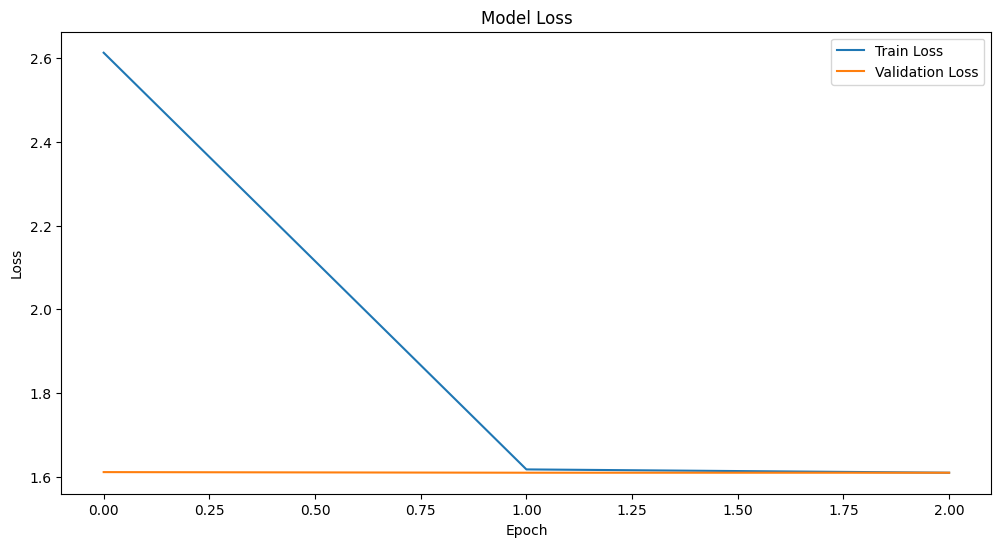

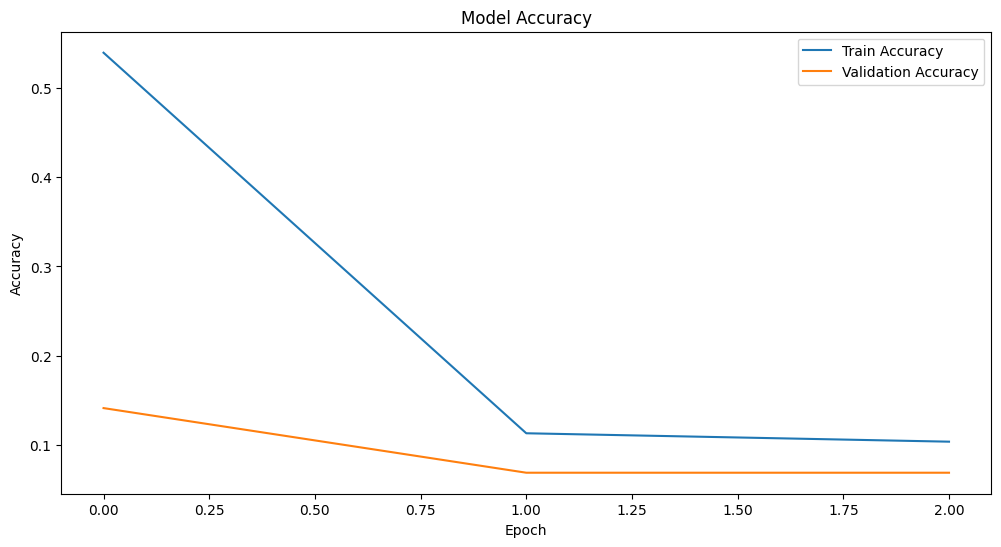

In [33]:
# Compile model
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=len(train_data) // BATCH_SIZE * NUM_EPOCHS)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=NUM_EPOCHS)

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [34]:
# Testing with inputs
input_text = [
    "This movie looks very interesting, I love the fact that the actors do a great job in showing how people lived in the 18th century, which wasn't very good at all. But at least this movie recreates these scenes!",
    "Very good start, but the movie started becoming uninteresting at some point though initially I thought it would have been much more fun. There was too much background noise, but later on towards the middle of the movie, my favorite character got in and he did a great job, so overall."]

input_text_pre = [preprocess_text(txt) for txt in input_text]

test_inputs = tokenizer(input_text_pre, padding=True, return_tensors="tf")

# Get logits
logits = model(**test_inputs).logits
print("logits:")
print(logits)


# Apply softmax to logits to get probabilities
probabilities = tf.nn.softmax(logits, axis=-1)
print("probabilities:")
print(probabilities)

# Sentinent
print("Sentinent:")
print(tf.argmax(probabilities,1)+1)

logits:
tf.Tensor(
[[-0.7720876  -0.70576197 -1.188272   -0.7897118  -2.3994806 ]
 [-0.77066875 -0.7122409  -1.1922243  -0.79302484 -2.3996558 ]], shape=(2, 5), dtype=float32)
probabilities:
tf.Tensor(
[[0.25594404 0.2734953  0.16881008 0.25147274 0.0502779 ]
 [0.25705525 0.27252188 0.16863482 0.25137228 0.05041577]], shape=(2, 5), dtype=float32)
Sentinent:
tf.Tensor([2 2], shape=(2,), dtype=int64)


# Run on Test Data

In [35]:
test_df =pd.read_csv('/content/test_data.csv')
test_df['reviewText_pre'] = test_df['reviewText'].apply(preprocess_text)
test_df['word_count'] = test_df['reviewText_pre'].apply(word_count)

test_df.describe()

,vote,unixReviewTime,word_count
count,4933.000000,2.000000e+04,20000.000000
mean,7.452058,1.483849e+09,59.405300
std,24.748409,2.239277e+07,62.854334
min,2.000000,1.451606e+09,4.000000
25%,2.000000,1.464998e+09,27.000000
50%,3.000000,1.480378e+09,39.000000
75%,6.000000,1.500422e+09,67.000000
max,831.000000,1.538093e+09,1555.000000


In [36]:
from tqdm import tqdm
for i,row in tqdm(test_df.iterrows(),  total=test_df.shape[0]):
    token = tokenizer(row['reviewText_pre'], padding=True, return_tensors="tf")
    logits = model(token).logits
    probabilities = tf.nn.softmax(logits, axis=-1)
    sentinent = tf.argmax(probabilities,1)+1
    
    test_df.loc[i,'predicted'] = int(sentinent)

100%|██████████| 20000/20000 [1:10:39<00:00,  4.72it/s]


In [37]:
# # Testing with inputs
# input_text = test_df["reviewText_pre"].tolist()

# test_inputs = tokenizer(input_text, padding=True, return_tensors="tf")

# # Get logits
# logits = model(**test_inputs).logits
# print("logits:")
# print(logits)


# # Apply softmax to logits to get probabilities
# probabilities = tf.nn.softmax(logits, axis=-1)
# print("probabilities:")
# print(probabilities)

# # Sentinent
# print("Sentinent:")
# print(tf.argmax(probabilities,1)+1)

In [38]:
test_df['predicted'].to_csv('q2_submission.csv', index=False)